# Анализ поведения пользователей в приложении "Не нужные вещи"

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
    
**Описание проекта:**

Пользователи мобильного приложения "Ненужные вещи" продают через него свои ненужные вещи, размещая объявление в приложении на доске. Необходимо проанализировать пользовательский опыт с 07.10.2019 по данным. Данные содержат действия пользователей в 
приложении по времени.
</div>

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

**Цель проекта:**
    
Изучить поведение пользователей. По полученным данным дать рекомендации по улучшению пользовательского опыта. 
</div>

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

**Описание данных:**

В датасете содержатся данные пользователей, впервые совершивших действия в
приложении после 7 октября 2019 года.

Датасет  в /datasets/mobile_sources.csv :
* userId — идентификатор пользователя,
* source — источник, с которого пользователь установил приложение.

Датасет в /datasets/mobile_dataset.csv :
* event.time — время совершения,
* user.id — идентификатор пользователя,
* event.name — действие пользователя.
    
    Виды действий:

* advert_open — открыл карточки объявления,
* photos_show — просмотрел фотографий в объявлении,
* tips_show — увидел рекомендованные объявления,
* tips_click — кликнул по рекомендованному объявлению,
* contacts_show и show_contacts — посмотрел номер телефона,
* contacts_call — позвонил по номеру из объявления,
* map — открыл карту объявлений,
* search_1 — search_7 — разные действия, связанные с поиском по сайту,
* favorites_add — добавил объявление в избранное.
</div>



<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

**План выполнения проекта**
    
1. Презентация.
2. Дашборд
3. Предобработка данных.  
    Загрузить данные и изучить общую информацию.
4. Исследовательский анализ данных.  
    Изучить дубликаты.  
    Найти при наличии пропуски данных.  
    Столбец event.time перевести в тим "datatime".  
    Провести работу с contacts_show и show_contacts как неявными дубликатами.  
    Столбец event.name привести к 9 действим в соответсвии с описанием данных.  
    Столбец event.time перевести в тим "datatime". 
5. Обработка данных.    
    Добавить столбец с сессией. Для этого понять, как разделять данные на сессии.  
    Избавиться от повторяющихся событий внутри сессии.
6. Анализ данных.  
    Проанализировать связь целевого события — просмотра контактов — и других действий пользователей
* 6.1. В разрезе сессий отобрать сценарии\паттерны, которые приводят к просмотру контактов.
* 6.2. Построить воронки по основным сценариям в разрезе уникальных пользователей оценить, какие действия чаще совершают те пользователи, которые просматривают контакты.
* 6.3. Рассчитать относительную частоту событий в разрезе двух групп пользователей: группа пользователей, которые смотрели контакты contacts_show группа пользователей, которые не смотрели контакты contacts_show.
7. Проверка статистических гипотез.
* 7.1 Гипотеза: конверсия в просмотры контактов у групп пользователей которые совершают действия tips_show и tips_click и у пользователей которые совершают только tips_show различается.
* 7.2 Гипотеза: Конверсия в просмотры контактов у групп пользователей, которые совершают photos_show  и те кто не совершает photos_show  различаются.
8. Общий вывод

</div>

## 1. Презентация
Ссылка на презентацию:  https://disk.yandex.ru/i/T4TP3dCOqNCNdQ


## 2. Дашборд
Ссылка на дашборд: https://public.tableau.com/views/Final2_17007457175230/sheet4?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

## 3. Предобработка данных.
Загрузка данных и общей информации

In [93]:
import pandas as pd
from datetime import timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import plotly.express as px
from IPython.display import display

In [94]:
mobile_source = pd.read_csv('/datasets/mobile_sources.csv')

In [95]:
display(mobile_source.head(5))
display(mobile_source.shape)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


(4293, 2)

In [96]:
try:
    mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
except:
     mobile_dataset = pd.read_csv('/datasets/mobile_dataset.csv')

In [97]:
display(mobile_dataset.head(5))
display(mobile_dataset.shape)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


(74197, 3)

In [98]:
# Объединение данных по идентификатору пользователя
df = pd.merge(mobile_dataset, mobile_source, left_on="user.id", right_on="userId", how="left")

In [99]:
# Удаление лишних колонок
df = df.drop(columns=["userId"])

In [100]:
# Выводим общею информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
 3   source      74197 non-null  object
dtypes: object(4)
memory usage: 2.8+ MB


## 3. Вывод
Отметили, что датасет mobile_dataset имеет некорректный тип данных для даты. Так же названия столбцов необходимо привести к хорошему стилю. Произведем корректировку в следующем шаге. 

## 4. Исследовательский анализ данных

In [101]:
# Преобразование формата времени
df["event.time"] = pd.to_datetime(df["event.time"]).dt.floor('S')
df = df.sort_values(by=["user.id", "event.time"])

In [102]:
# Работа с контактами как неявными дубликатами
df["event.name"] = df["event.name"].replace({"show_contacts": "contacts_show"})
df["event.name"] = df["event.name"].apply(lambda x: "search" if x.startswith("search_") else x)

In [103]:
# проверим event.name 
print(df['event.name'].unique ())

['tips_show' 'map' 'search' 'photos_show' 'favorites_add' 'contacts_show'
 'contacts_call' 'advert_open' 'tips_click']


In [104]:
# КОД РЕВЬЮЕРА

df["event.name"].unique()

array(['tips_show', 'map', 'search', 'photos_show', 'favorites_add',
       'contacts_show', 'contacts_call', 'advert_open', 'tips_click'],
      dtype=object)

Получили 9 видов действий пользователя на сайте, что соответствует описанию данных изначальной задачи.

In [105]:
# Приведение столбца event.name к 9 действиям
actions = ["advert_open", "photos_show", "tips_show", "tips_click", "contacts_show", "contacts_call", "map", "search", "favorites_add"]
df = df[df["event.name"].isin(actions)]

In [106]:
# приведем названия столбцов к хорошему стилю
df.columns = ['event_time', 'event_name', 'user_id', 'source']

In [107]:
# проверяем уникальные данные
display(df.nunique())

event_time    71291
event_name        9
user_id        4293
source            3
dtype: int64

In [108]:
df['event_name'] = df['event_name']. replace('contacts_show', 'show_contacts')

In [109]:
# Поиск пропусков
missing_values = df.isnull().sum()
print("Пропуски данных:")
print(missing_values)

Пропуски данных:
event_time    0
event_name    0
user_id       0
source        0
dtype: int64


In [110]:
# Изучение дубликатов
duplicates = df[df.duplicated()]
print("Количество дубликатов:", duplicates.shape[0])

Количество дубликатов: 1224


In [111]:
# Удаление дубликатов
df = df.drop_duplicates()

In [112]:
# Узнаем сколько дней велось наблюдение. 
print(min(df['event_time']))
print(max(df['event_time']))

2019-10-07 00:00:00
2019-11-03 23:58:12


## 4. Вывод
Привела наименование данных к хорошему стилю.  
В данных отсутствуют пропуски.  
Произвела замену в столбце event_name для получения 9 действий в соответствии с описанием данных.  
Привела event_time к datetime, что необходимо для последующей работы с сессиями. Привела   event_time к времени до секунд.  Так как оставленные в датафрейме милисекунды создают неочевилные дубли.
Обработала дубликаты.  
Наблюдение велось с 7 октября 2019 года по 3 ноября 2019 года, что составляет 27 дней.  
Мы имеем датасет из почти 73 тыс. событий.  
У нас 4293 пользователя по которым велось наблюдение в данный период.  
Мы можем сказать, что такой объем данных может дать объективную картину поведения пользователя в приложении.


## 5. Обработка данных

In [113]:
# Сортировка данных
df = df.sort_values(by=['user_id', 'event_time'])

In [114]:
# Расчет временных интервалов между событиями
df['time_diff'] = df.groupby('user_id')['event_time'].diff().dt.total_seconds()

In [115]:
# Расчет IQR
Q1 = df['time_diff'].quantile(0.25)
Q3 = df['time_diff'].quantile(0.75)
IQR = Q3 - Q1

In [116]:
# Определение верхней границы для таймаута сессии
upper_bound = Q3 + 1.5 * IQR
print(upper_bound)
print(Q1, Q3)

421.0
26.0 184.0


Расчет IQR (межквартильного размаха): Мы рассчитали первый (Q1) и третий (Q3) квартили для time_diff, а затем вычислили межквартильный размах (IQR) как разность между Q3 и Q1.  
IQR используется в статистике для определения степени разброса и выявления выбросов в данных.  
Расчет IQR был необходим для того, чтобы определить, какие временные интервалы между событиями можно считать обычными, а какие являются необычными или аномальными.  
Определение верхней границы для таймаута сессии: На основе IQR мы определили верхнюю границу таймаута сессии. Эта граница была установлена как Q3 плюс 1.5, умноженное на IQR. Это время составило 421 секунду. Любое время простоя между событиями, превышающее эту верхнюю границу, можно рассматривать как окончание одной сессии и начало другой.  
Определение верхней границы таймаута сессии было необходимо для того, чтобы разграничить отдельные сессии пользователей в анализе. Это позволяет анализировать поведение пользователя в рамках отдельных сессий и делать выводы о паттернах использования приложения.

In [117]:
# Фильтрация данных, чтобы избежать нулевых и отрицательных значений
filtered_data = df[df['time_diff'] > 0]

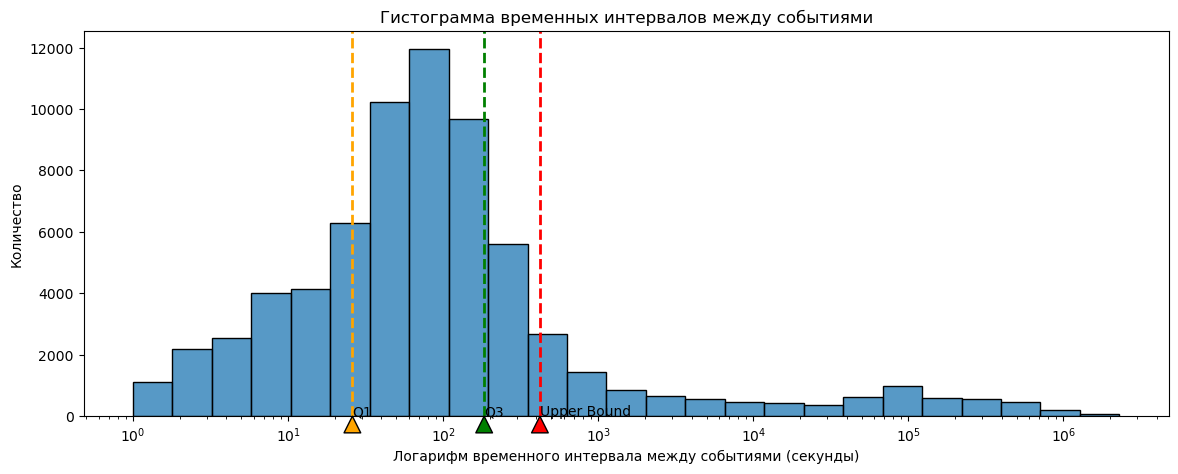

In [118]:
# Построение гистограммы с логарифмической шкалой
plt.figure(figsize=(14, 5))
sns.histplot(filtered_data['time_diff'], bins=25, kde=False, log_scale=True)
plt.xlabel('Логарифм временного интервала между событиями (секунды)')
plt.ylabel('Количество')
plt.title('Гистограмма временных интервалов между событиями')

# Добавление линий процентилей и верхней границы
plt.axvline(Q1, color='orange', linestyle='dashed', linewidth=2)
plt.axvline(Q3, color='green', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=2)

# Аннотации
plt.annotate('Q1', xy=(Q1, 0), xytext=(Q1, 5), arrowprops=dict(facecolor='orange', shrink=0.05))
plt.annotate('Q3', xy=(Q3, 0), xytext=(Q3, 5), arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate('Upper Bound', xy=(upper_bound, 0), xytext=(upper_bound, 5), arrowprops=dict(facecolor='red', shrink=0.05))

# Показать график
plt.show()

Вычислив  межквартальный размах (IQR)  мы узнали, что в большинстве случаев на одно действие пользователю требуется от 0,5  до 3 минут.  
В данных полученных нами при наблюдении 12000 раз действие пользователя длилось 1,5 минут.  
Вычислили верхнюю границу для таймаута сессии и узнали, что она составляет 7 минут.  
Мы можем анализировать поведение пользователя в рамках отдельных сессий и делать выводы о паттернах использования приложения.  
Спустя 7 минут пользователь начинает уже новую сессию, возможно пользователь повторяет ранее использованный им алгоритм действий. Изучим это далее.



In [119]:
# Идентификация новых сессий
df['new_session'] = df['time_diff'] > upper_bound

In [120]:
# Назначение ID сессии
df['session_id'] = df.groupby('user_id')['new_session'].cumsum().fillna(0)

In [121]:
# Расчет продолжительности сессии
df['session_duration'] = df.groupby(['user_id', 'session_id'])['event_time'].transform(lambda x: x.max() - x.min())

In [122]:
# Расчет начала и окончания каждой сессии
session_start_end = df.groupby(['user_id', 'session_id'])['event_time'].agg(['min', 'max'])

In [123]:
# Расчет длительности сессии
session_start_end['session_duration'] = (session_start_end['max'] - session_start_end['min']).dt.total_seconds()

In [124]:
# Объединение с основным датафреймом
#df = pd.merge(df, session_duration[['user_id', 'session_id', 'session_duration']], on=['user_id', 'session_id'], how='left')

In [125]:
# Расчет таймаута между сессиями
session_start_end['next_session_start'] = session_start_end.groupby('user_id')['min'].shift(-1)
session_start_end['session_timeout'] = (session_start_end['next_session_start'] - session_start_end['max']).dt.total_seconds()

In [126]:
# Удаление отрицательных значений, нулевых значений и NaN
session_start_end = session_start_end[(session_start_end['session_duration'] > 0) & (session_start_end['session_timeout'] > 0)]
session_start_end.dropna(subset=['session_duration', 'session_timeout'], inplace=True)


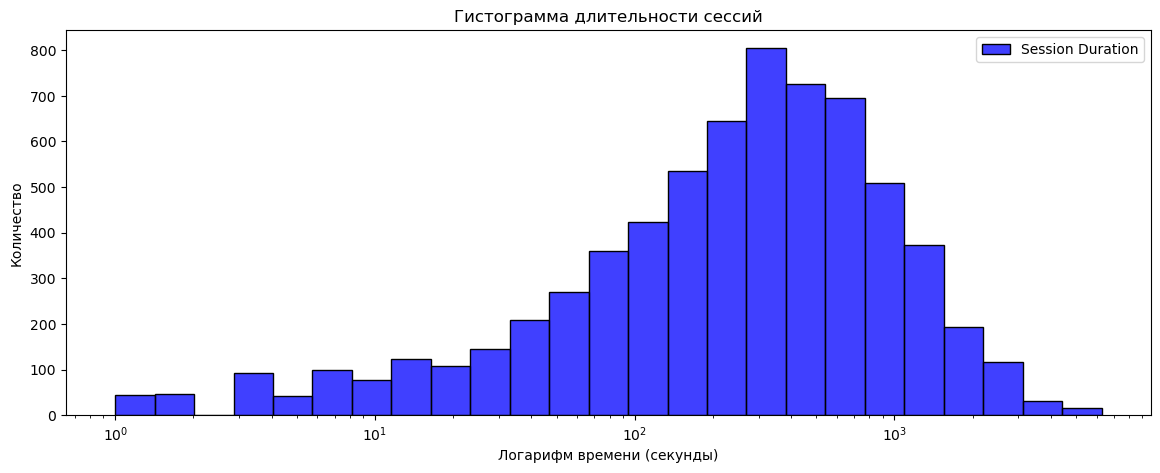

In [127]:
# Гистограмма длительности сессий и таймаутов
plt.figure(figsize=(14, 5))
sns.histplot(session_start_end['session_duration'], bins=25, color='blue', kde=False, log_scale=True, label='Session Duration')
plt.xlabel('Логарифм времени (секунды)')
plt.ylabel('Количество')
plt.title('Гистограмма длительности сессий')
plt.legend()
plt.show()

Построив гистрагграмму длительности сессий,  мы узнали, что наибольшее количество сессий длиться 5 минут. Подобных сессий около 800 в наблюдениях которые мы получили за наблюдаемый отрезок времени.  
Так же можно сказать, что гистраграмма имеет распределение длительности сессий близкое к нормальному распределении с пиком на 5 минутах и снижением количества сессий, длящихся больше или меньше этого времени.


In [128]:
# Удаление временных столбцов
df.drop(columns=['time_diff', 'new_session'], inplace=True)

In [129]:
# Группировка по пользователям и сессиям, агрегация данных
session_aggregated = df.groupby(['user_id', 'session_id']).agg({
    'event_time': ['min', 'max'],
    'event_name': lambda x: list(x)
}).reset_index()

# Вычисление длительности каждой сессии
session_aggregated['session_duration'] = (session_aggregated['event_time']['max'] - session_aggregated['event_time']['min']).dt.total_seconds()

# Переименование столбцов
session_aggregated.columns = ['user_id', 'session_id', 'start_time', 'end_time', 'event_names', 'session_duration']



In [130]:
session_aggregated.describe()

,session_id,session_duration
count,14146.000000,14146.000000
mean,5.455677,350.947618
std,12.191052,554.963968
min,0.000000,0.000000
25%,0.000000,0.000000
50%,2.000000,148.000000
75%,5.000000,469.000000
max,134.000000,7711.000000


In [131]:
session_aggregated

,user_id,session_id,start_time,end_time,event_names,session_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,2019-10-07 13:39:45,2019-10-07 13:49:41,"[tips_show, tips_show, tips_show, tips_show, t...",596.0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-09 18:33:55,2019-10-09 18:42:22,"[map, map, tips_show, tips_show]",507.0
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,2019-10-21 19:52:30,2019-10-21 20:07:30,"[tips_show, tips_show, map, tips_show, tips_sh...",900.0
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,2019-10-22 11:18:14,2019-10-22 11:30:52,"[map, tips_show, tips_show, tips_show, map, ti...",758.0
4,00157779-810c-4498-9e05-a1e9e3cedf93,0,2019-10-19 21:34:33,2019-10-19 21:46:52,"[search, search, search, photos_show, photos_s...",739.0
...,...,...,...,...,...,...
14141,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,40,2019-11-02 19:25:53,2019-11-02 19:30:50,"[tips_show, show_contacts, tips_show, tips_show]",297.0
14142,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,41,2019-11-03 14:32:55,2019-11-03 14:48:44,"[tips_show, show_contacts, tips_show, show_con...",949.0
14143,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,42,2019-11-03 15:36:01,2019-11-03 15:37:43,"[tips_show, tips_show, tips_show, tips_show]",102.0
14144,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,43,2019-11-03 15:47:43,2019-11-03 15:51:57,"[tips_show, show_contacts, tips_show, tips_sho...",254.0


In [132]:
display(df.sample(10))

,event_time,event_name,user_id,source,session_id,session_duration
65433,2019-10-31 15:22:12,photos_show,6383ff6a-04b8-4562-a98f-bb4f760d3c39,other,46,0 days 00:00:00
6218,2019-10-09 15:54:20,tips_show,c83d8f7c-3b43-495c-94db-3aac32dbed98,other,0,0 days 00:24:25
56764,2019-10-28 16:47:01,tips_show,472754c2-e86c-47c8-9c46-3c3a2ced94ec,yandex,0,0 days 00:15:50
34156,2019-10-21 00:08:58,search,858718c3-7c31-4fa2-bbeb-425fd02be083,google,0,0 days 00:13:07
3972,2019-10-08 15:56:56,map,9ce63488-758a-481a-bcb5-a02b467e1d84,yandex,6,0 days 01:10:49
2799,2019-10-08 10:31:18,contacts_call,5394784c-cc24-4156-b4ad-3b2cbbb665f4,yandex,0,0 days 00:08:52
72238,2019-11-03 14:10:51,tips_show,e0a19ff5-468c-4c47-8dc4-bc4eb9854a96,yandex,1,0 days 01:41:52
55663,2019-10-28 12:38:11,map,5000eb49-050b-439d-9feb-9002501ec600,google,10,0 days 00:00:00
19575,2019-10-15 12:58:24,tips_show,636601f0-7c84-4bde-a319-8f1211548db2,other,4,0 days 00:00:00
57084,2019-10-28 18:39:07,tips_show,c2a65ac2-331d-4fdc-9dc8-2a0f8a0a3a1a,other,0,0 days 00:09:48


## 5. Вывод
Рассчитали временные интервалы между событиями.  
С помощью расчета IQR узнали, что таймаут между сессиями составляет 7 минут, после чего ранее начатую сессию можно считать завершённой.  
Узнали, что стандартная сессия пользователя длиться 5 минут.
Разбили данные на сессии добавив столбец с идентификатором сессии.  
Подготовили данные для дальше него анализа.



## 6. Анализ данных.

In [133]:
# Определение пользователей, просматривавших контакты
users_viewing_contacts = df[df['event_name'] == 'show_contacts']['user_id'].unique()

In [134]:
# Анализ действий пользователей, просматривавших контакты
actions_viewing_contacts = df[df['user_id'].isin(users_viewing_contacts)]['event_name'].value_counts()

In [135]:
# Анализ действий пользователей, не просматривавших контакты
actions_not_viewing_contacts = df[~df['user_id'].isin(users_viewing_contacts)]['event_name'].value_counts()

In [136]:
# Вывод результатов
print("Действия пользователей, просматривавших контакты:")
print(actions_viewing_contacts)
print("\nДействия пользователей, не просматривавших контакты:")
print(actions_not_viewing_contacts)

Действия пользователей, просматривавших контакты:
tips_show        12708
show_contacts     4376
photos_show       3483
search            2063
advert_open       1585
map               1057
contacts_call      534
favorites_add      422
tips_click         332
Name: event_name, dtype: int64

Действия пользователей, не просматривавших контакты:
tips_show        27199
photos_show       5869
search            4621
advert_open       4561
map               2692
favorites_add      992
tips_click         479
Name: event_name, dtype: int64


In [137]:
# Создание списка уникальных действий
unique_actions = list(set(actions_viewing_contacts.index).union(set(actions_not_viewing_contacts.index)))

In [138]:
# Сопоставление количества для каждого действия в обеих группах
viewing_counts = [actions_viewing_contacts.get(action, 0) for action in unique_actions]
not_viewing_counts = [actions_not_viewing_contacts.get(action, 0) for action in unique_actions]

In [139]:
# Установка позиций для каждой группы на оси X
y = np.arange(len(unique_actions))
height = 0.45  

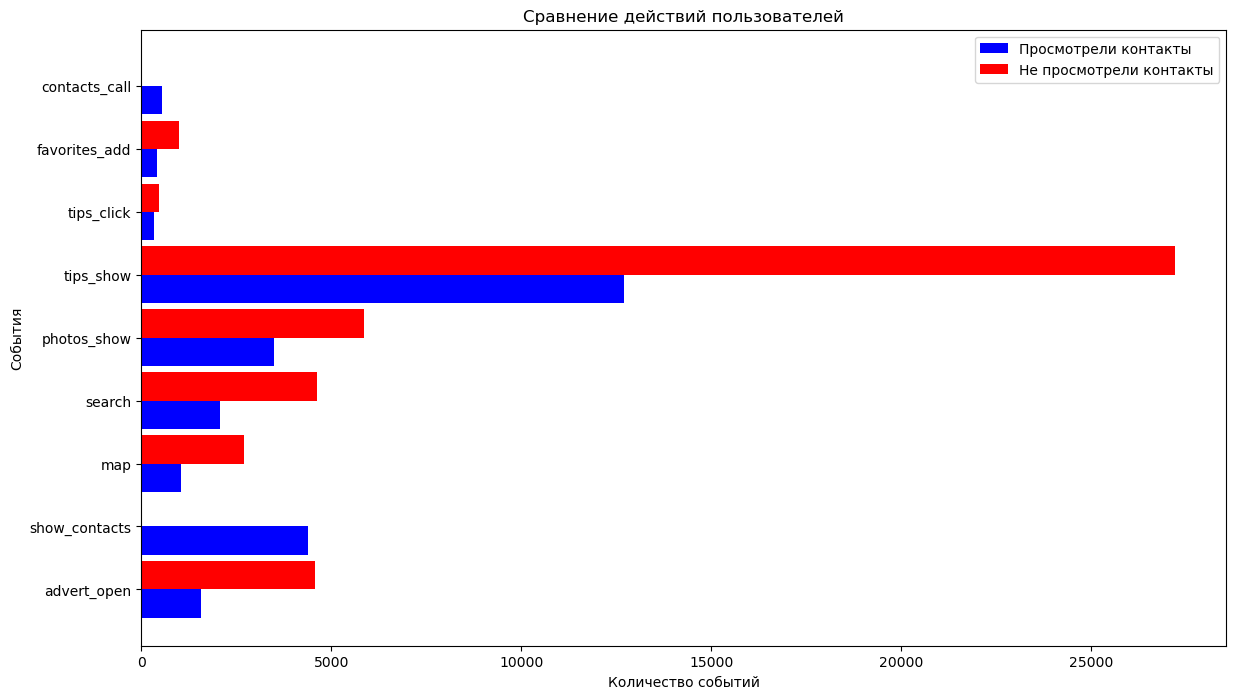

In [140]:
# Создание графика
plt.figure(figsize=(14, 8))
bars1 = plt.barh(y - height/2, viewing_counts, height, label='Просмотрели контакты', color='blue')
bars2 = plt.barh(y + height/2, not_viewing_counts, height, label='Не просмотрели контакты', color='red')

# Добавление подписей и легенды
plt.xlabel('Количество событий')
plt.ylabel('События')
plt.title('Сравнение действий пользователей')
plt.yticks(y, unique_actions)
plt.legend()

# Показать график
plt.show()

Построили график по двум группам пользователей: совершивших целевое действие "просмотр контакта" (show-contacts) и не совершивших.  
Самым популярным среди обеих групп является действие "увидел рекомендованные объявления". Нужно отметить, что среди нецелевой группы данное действие было совершено более 27000 раз, а среди целевой группы около 13000 раз.  
Вторым по популярности действием является просмотр фото, и опять в нецелевой группе это действие совершалось почти в два раза чаще чем в целевой.  
Действие "кликнул по рекомендованному объявлению" является неимение популярным. Вероятно, отслеживании алгоритма действия пользователей данное действе не является необходимым, так как совершить целевое действие, просмотреть контакты можно и без tips-click.

In [141]:
# Распределение событий
event_counts = df['event_name'].value_counts()

In [142]:
# Активность пользователей по времени
df['event_time'] = pd.to_datetime(df['event_time'])
events_over_time = df.groupby(df['event_time'].dt.date).count()['event_name']

In [143]:
# Вывод результатов
print("Распределение событий:")
print(event_counts)
print("\nАктивность пользователей по времени:")
print(events_over_time)

Распределение событий:
tips_show        39907
photos_show       9352
search            6684
advert_open       6146
show_contacts     4376
map               3749
favorites_add     1414
tips_click         811
contacts_call      534
Name: event_name, dtype: int64

Активность пользователей по времени:
event_time
2019-10-07    2518
2019-10-08    2453
2019-10-09    2010
2019-10-10    2222
2019-10-11    1951
2019-10-12    1809
2019-10-13    2605
2019-10-14    3003
2019-10-15    2671
2019-10-16    2676
2019-10-17    2564
2019-10-18    2713
2019-10-19    2301
2019-10-20    2106
2019-10-21    2853
2019-10-22    2698
2019-10-23    3248
2019-10-24    2991
2019-10-25    2583
2019-10-26    3050
2019-10-27    2758
2019-10-28    3156
2019-10-29    3160
2019-10-30    2842
2019-10-31    2830
2019-11-01    2552
2019-11-02    1820
2019-11-03    2830
Name: event_name, dtype: int64


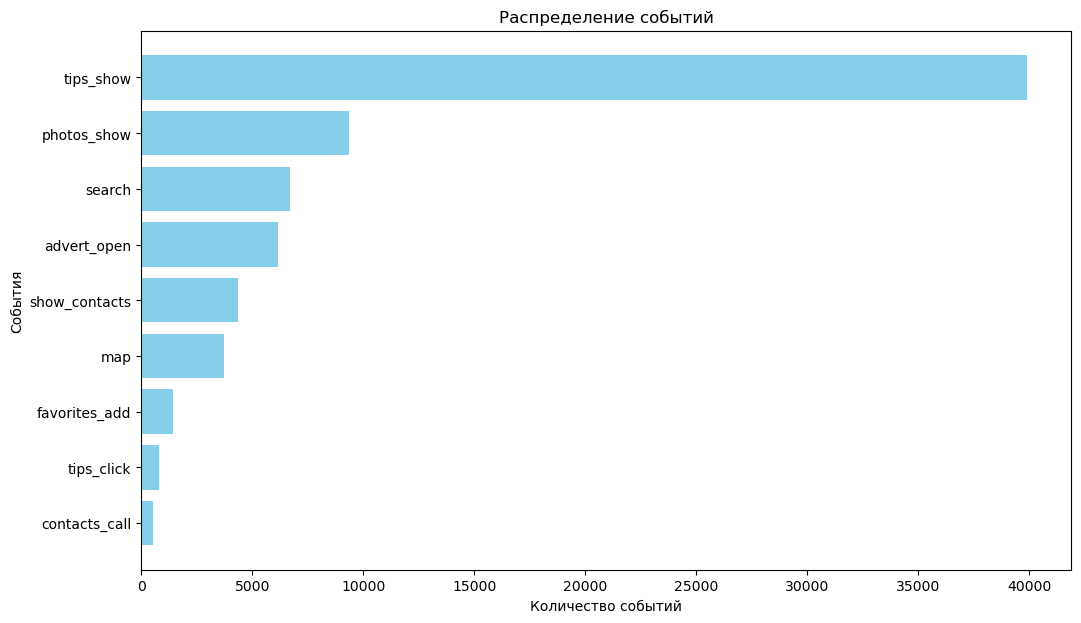

In [144]:
# Построение гистограммы распределения событий
plt.figure(figsize=(12, 7))
plt.barh(event_counts.index, event_counts.values, color='skyblue')
plt.xlabel('Количество событий')
plt.ylabel('События')
plt.title('Распределение событий')
plt.gca().invert_yaxis()
plt.show()

Визуализировали частоту действий пользователей без разбивки на целевую и не целевую группу и выяснили:
* Первое по популярности действие "увидел рекомендованное объявление" за период наблюдение произошло около 40 000 раз.
* "Просмотр фото" второе по популярности действие произошло около 9 000 раз. 
* Снова мы видим в аутсайдерах "кликнул по рекомендованному объявлению" около 800 раз. 
* На последнем "позвонил по номеру из объявления" 500 раз. По этому поводу мы можем сказать, что данный функционал приложения для большинства пользователей не является  ценным.

In [145]:
# Целевое событие
target_event = 'show_contacts'

In [146]:
# Определение пользователей, совершивших целевое событие
users_target_event = df[df['event_name'] == target_event]['user_id'].unique()

In [147]:
# Анализ действий до совершения целевого события
df_target_users = df[df['user_id'].isin(users_target_event)]
df_target_users = df_target_users.sort_values(by=['user_id', 'session_id', 'event_time'])

In [148]:
# Определение последовательности событий перед целевым событием
df_target_users['prev_event'] = df_target_users.groupby(['user_id', 'session_id'])['event_name'].shift(1)
events_before_target = df_target_users[df_target_users['event_name'] == target_event]['prev_event'].value_counts()

In [149]:
print("События, предшествующие целевому событию:")
print(events_before_target)

События, предшествующие целевому событию:
tips_show        1594
show_contacts    1177
photos_show       304
search            176
contacts_call     126
advert_open        65
map                52
favorites_add      38
tips_click          6
Name: prev_event, dtype: int64


In [150]:
# Определение пользователей, совершивших целевое событие
users_target_event = df[df['event_name'] == target_event]['user_id'].unique()

In [151]:
# Фильтрация событий, совершенных этими пользователями
df_target_users = df[df['user_id'].isin(users_target_event)]

In [152]:
# Сортировка по пользователям и времени
df_target_users = df_target_users.sort_values(by=['user_id', 'event_time'])

In [153]:
# Определение предшествующего события для каждого целевого события
df_target_users['prev_event'] = df_target_users.groupby('user_id')['event_name'].shift(1)

In [154]:
# Подсчет предшествующих событий
events_before_target = df_target_users[df_target_users['event_name'] == target_event]['prev_event'].value_counts()

In [155]:
# Исключение события 'show_contacts' из данных
events_before_target = events_before_target[events_before_target.index != 'show_contacts']

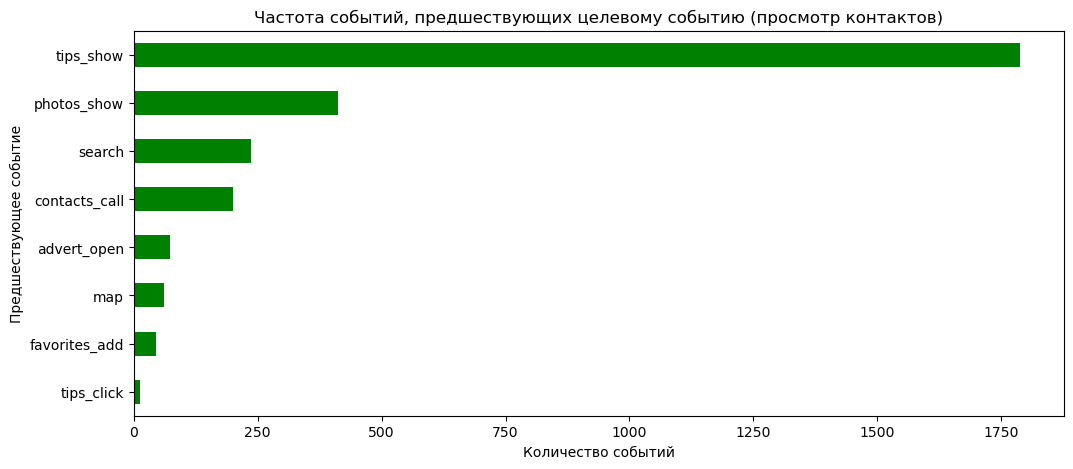

In [156]:
# Построение графика
plt.figure(figsize=(12, 5))
events_before_target.plot(kind='barh', color='green')
plt.xlabel('Количество событий')
plt.ylabel('Предшествующее событие')
plt.title('Частота событий, предшествующих целевому событию (просмотр контактов)')
plt.gca().invert_yaxis()  # Переворачиваем ось Y
plt.show()

Для анализа поведения пользователей построили гистограмму «Частота событий, предшествующих целевому событию (просмотр контактов)».  
Действие "увидел рекомендованное объявление" (1750 раз пользователи увидели объявление, прежде чем взять контакт) является самым эффективным и дает больше всего переводов к целевому действию. Это может говорить как об удачном алгоритме как рекламы нашего приложения (входы со сторонних ресурсов), так и эффективной первой страницы нашего приложения.  
Наличие фотографий в объявлениях привлекает пользователей. Быть может стоить рекомендовать всем пользователям публикующим объявление добавить фото, чтобы ускорить продажу их ненужных вещей, а для нас как для приложения, это позволит заинтересовать больше целевых пользователей.


In [157]:
# Сортировка данных по пользователям, сессиям и времени
df_sorted = df.sort_values(by=['user_id', 'session_id', 'event_time'])

# Словарь для хранения цепочек действий
session_action_chains = {}

# Обработка данных для каждой сессии
for (user_id, session_id), actions in df_sorted.groupby(['user_id', 'session_id'])['event_name']:
    actions_list = actions.tolist()
    if 'show_contacts' in actions_list:
        # Отбор событий до первого появления 'show_contacts' включительно
        chain_actions = actions_list[:actions_list.index('show_contacts') + 1]

        # Удаление непосредственно повторяющихся действий
        filtered_actions = [chain_actions[i] for i in range(len(chain_actions)) if i == 0 or chain_actions[i] != chain_actions[i-1]]

        # Пропускаем цепочки, состоящие только из одного действия 'show_contacts'
        if len(filtered_actions) <= 1:
            continue

        # Формирование уникальной цепочки
        chain = ' -> '.join(filtered_actions)

        # Подсчет частоты каждой цепочки
        session_action_chains[chain] = session_action_chains.get(chain, 0) + 1

# Фильтрация и сортировка цепочек по частоте
popular_chains_sorted = sorted([(k, v) for k, v in session_action_chains.items() if v > 1], key=lambda x: -x[1])

# Вывод результатов
print("Самые популярные сценарии действий в сессиях:")
for chain, count in popular_chains_sorted[:5]:
    print(f"{chain}: {count} раз")


Самые популярные сценарии действий в сессиях:
tips_show -> show_contacts: 546 раз
photos_show -> show_contacts: 151 раз
search -> show_contacts: 140 раз
map -> tips_show -> show_contacts: 78 раз
search -> photos_show -> show_contacts: 43 раз


In [158]:
# Преобразование отсортированных цепочек в словарь
scenarios = {}
for chain, count in popular_chains_sorted[:5]:
    scenarios[chain] = count

# Вывод словаря
print("Сценарии и количество пользователей:")
for scenario, count in scenarios.items():
    print(f"{scenario}: {count}")

Сценарии и количество пользователей:
tips_show -> show_contacts: 546
photos_show -> show_contacts: 151
search -> show_contacts: 140
map -> tips_show -> show_contacts: 78
search -> photos_show -> show_contacts: 43


In [159]:
# Инициализация списков
scenarios = []
final_counts = []

# Заполнение списков данными из отсортированных популярных цепочек
for chain, count in popular_chains_sorted[:5]:
    scenarios.append(chain)
    final_counts.append(count)

# Вывод результата
print("Сценарии:")
print(scenarios)
print("Количество пользователей по сценариям:")
print(final_counts)


Сценарии:
['tips_show -> show_contacts', 'photos_show -> show_contacts', 'search -> show_contacts', 'map -> tips_show -> show_contacts', 'search -> photos_show -> show_contacts']
Количество пользователей по сценариям:
[546, 151, 140, 78, 43]


In [185]:
# Функция для построения воронки
def build_funnel(scenario, final_count):
    steps = scenario.split(' -> ')
    step_counts = []
    percentages = []  # Добавляем список для хранения процентов
    df_filtered = df.copy()

    for step in steps[:-1]:
        users_at_step = set(df_filtered[df_filtered['event_name'] == step]['user_id'])
        step_counts.append(len(users_at_step))
        df_filtered = df_filtered[df_filtered['user_id'].isin(users_at_step)]

    step_counts.append(final_count)

    total_users = step_counts[0]  # Исходное количество пользователей
    for count in step_counts:
        percentage = (count / total_users) * 100  # Расчет процента
        percentages.append(f"{percentage:.2f}%")  # Добавляем процент в форматированном виде

    # Создаем DataFrame для отображения на воронке
    funnel_data = {'Step': steps, 'Users': step_counts, 'Percentage': percentages}
    funnel_df = pd.DataFrame(funnel_data)

    # Создание воронки
    fig = px.funnel(funnel_df, y='Step', x='Users', text='Percentage')
    fig.update_layout(title=f"Воронка для сценария: {scenario}", yaxis_title="")
    return fig

# Построение и отображение воронок для каждого сценария
for scenario, final_count in zip(scenarios, final_counts):
    funnel_fig = build_funnel(scenario, final_count)
    display(funnel_fig)

Выделили и построили топ-5 самых популярных сценариев алгоритма действия пользователя в приложении.  
Данной визуализацией мы можем наглядно показать, что конверсия в целевое действие у нас в приложении колеблется от 2,3%до 10 %, что по анализу рынка является хорошей конверсией.  
Так же отметим, что пользователю для сов решения целевого действия необходимо совершить 2-3 действия, что говорит об userfrendly интерфейсе.


In [161]:
# Функция подсчета конверсии
def calculate_conversion(scenario, final_count):
    steps = scenario.split(' -> ')
    step_counts = []
    df_filtered = df.copy()

    for step in steps[:-1]:
        users_at_step = set(df_filtered[df_filtered['event_name'] == step]['user_id'])
        step_counts.append(len(users_at_step))
        df_filtered = df_filtered[df_filtered['user_id'].isin(users_at_step)]

    step_counts.append(final_count)
    
    conversions = []
    for i in range(len(step_counts) - 1):
        conversion = step_counts[i+1] / step_counts[i] * 100
        conversions.append(conversion)

    return step_counts, conversions

In [162]:
# Расчет и вывод конверсий для каждого сценария
for scenario, final_count in zip(scenarios, final_counts):
    step_counts, conversions = calculate_conversion(scenario, final_count)
    print(f"Конверсии для сценария '{scenario}':")
    for i, conversion in enumerate(conversions):
        print(f"Этап {i+1} к Этап {i+2}: {conversion:.2f}%")
    print("\n")

Конверсии для сценария 'tips_show -> show_contacts':
Этап 1 к Этап 2: 19.49%


Конверсии для сценария 'photos_show -> show_contacts':
Этап 1 к Этап 2: 13.79%


Конверсии для сценария 'search -> show_contacts':
Этап 1 к Этап 2: 8.40%


Конверсии для сценария 'map -> tips_show -> show_contacts':
Этап 1 к Этап 2: 92.86%
Этап 2 к Этап 3: 5.77%


Конверсии для сценария 'search -> photos_show -> show_contacts':
Этап 1 к Этап 2: 38.84%
Этап 2 к Этап 3: 6.65%




In [163]:
# Исключение 'tips_show' из списка уникальных действий
unique_actions = df['event_name'].unique()
unique_actions = [action for action in unique_actions if action != 'tips_show']

In [164]:
# Создание DataFrame, где строки - пользователи, а столбцы - действия
user_actions = pd.DataFrame(index=df['user_id'].unique(), columns=unique_actions)

In [165]:
# Заполнение DataFrame: 1, если пользователь совершил действие, иначе 0
for index, row in df.iterrows():
    if row['event_name'] in user_actions.columns:
        user_actions.at[row['user_id'], row['event_name']] = 1

user_actions = user_actions.fillna(0)

In [166]:
# Расчет корреляционной матрицы
correlation_matrix = user_actions.corr()

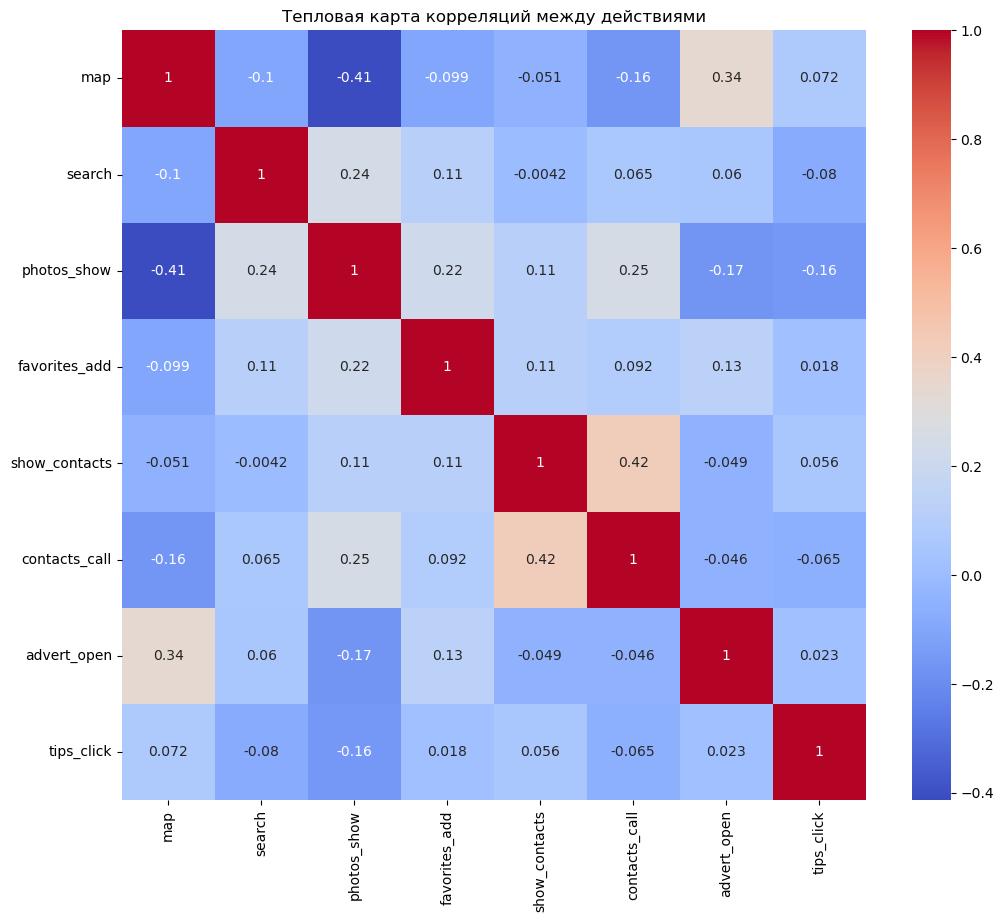

In [167]:
# Визуализация тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Тепловая карта корреляций между действиями")
plt.show()


Визуализировали корреляций между действиями и узнали, что больше всего связаны просмотр контакта и звонок из приложения, что несомненно, логично, так как позвонить без просмотра контакта в приложении вероятно не возможно. Так же можем отметить, что пользователи не связывают просмотр фото и просмотр карт, то уже не так очевидно. Вероятно, нашим пользователям неважно насколько далеко от них находиться понравившиеся им товар.
Но также, есть вероятность, что некоторые пользователи используют наше приложение не целевым образом и просто развлекают себя просмотром объявлений, мы можем так подумать, благодаря тому что в интернете часто возникают обсуждения смешных объявлений.  


In [168]:
# Словарь для хранения информации о сессиях
session_info = {}

In [169]:
# Проходим по данным и заполняем информацию о сессиях
for index, row in df.iterrows():
    session_id = row['session_id']
    event_name = 'search' if 'search' in row['event_name'] else row['event_name']

    if session_id not in session_info:
        session_info[session_id] = {'session_id': session_id, 'session_total': 1}

    session_info[session_id][event_name] = session_info[session_id].get(event_name, 0) + 1
    session_info[session_id]['session_total'] += 1

In [170]:
# Преобразование словаря в DataFrame
session_df = pd.DataFrame.from_dict(session_info, orient='index')

In [171]:
# Сортировка по общему количеству действий в сессии и выбор топ 9
top_sessions = session_df.sort_values(by='session_total', ascending=False).head(9)

In [172]:
# Вывод результата
display(top_sessions)
display(top_sessions.shape)

,session_id,session_total,tips_show,search,photos_show,map,show_contacts,contacts_call,advert_open,tips_click,favorites_add
0,0,29161,15915.0,3077.0,3504.0,1871.0,1328.0,159.0,2561.0,275.0,470.0
1,1,12212,6826.0,1068.0,1595.0,546.0,685.0,105.0,1019.0,119.0,248.0
2,2,7721,4366.0,571.0,1026.0,312.0,477.0,88.0,615.0,120.0,145.0
3,3,4211,2272.0,391.0,580.0,176.0,289.0,46.0,307.0,61.0,88.0
4,4,3306,1848.0,299.0,375.0,109.0,187.0,35.0,287.0,43.0,122.0
5,5,2216,1167.0,167.0,312.0,94.0,161.0,24.0,196.0,48.0,46.0
6,6,2109,1108.0,193.0,257.0,143.0,104.0,15.0,190.0,17.0,81.0
7,7,1558,881.0,136.0,239.0,46.0,76.0,11.0,113.0,23.0,32.0
8,8,1152,648.0,95.0,170.0,46.0,69.0,11.0,93.0,10.0,9.0


(9, 11)

In [173]:
# Определение пользователей, которые просмотрели контакты
users_viewing_contacts = df[df['event_name'] == 'show_contacts']['user_id'].unique()

In [174]:
# Сравнение частоты событий в процентах между группами
actions_viewing_contacts = df[df['user_id'].isin(users_viewing_contacts)]['event_name'].value_counts(normalize=True) * 100
actions_not_viewing_contacts = df[~df['user_id'].isin(users_viewing_contacts)]['event_name'].value_counts(normalize=True) * 100

In [175]:
# Подготовка данных для графика
comparison_df = pd.DataFrame({'Viewing Contacts': actions_viewing_contacts, 
                              'Not Viewing Contacts': actions_not_viewing_contacts})
comparison_df = comparison_df.fillna(0) # Заполнение нулями отсутствующих значений

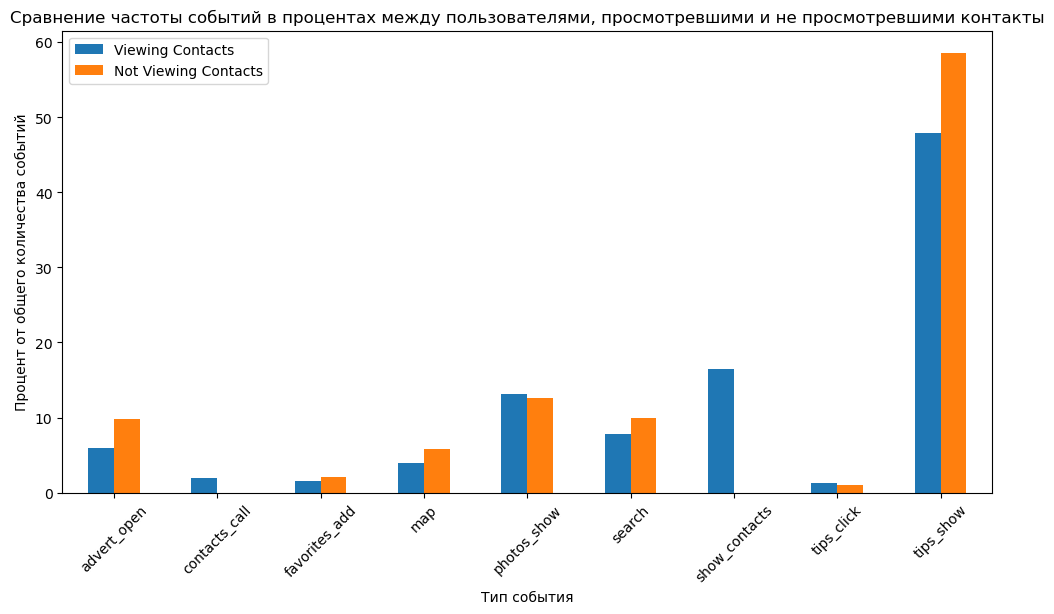

In [176]:
# Построение графика
comparison_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Тип события')
plt.ylabel('Процент от общего количества событий')
plt.title('Сравнение частоты событий в процентах между пользователями, просмотревшими и не просмотревшими контакты')
plt.xticks(rotation=45)
plt.show()

Строим госпрограмму "Сравнение частоты событий в процентах между пользователями, просмотревшими и не просмотревшими контакты".  
Узнали, что в процентом соотношении "увидел рекомендованное объявление" было совершено 60 % нецелевых и 50 % целевых пользователей.  
В то время как "кликнул по рекомендованному объявлению" использовали около 2% пользователей.


## 6. Вывод
Для проведения анализа разделили всех пользователи приложения на две группы: совершивших просмотр контактов и не просмотревших контакты.  
Выявили, что среди обеих групп пользователей, самым популярным действием стало: увидел рекомендованные объявления. При чем мы видим кратное превышение «увидел рекомендованные объявления» среди группы пользователей которые не совершили целевое действе.  
Среди группы просмотревших контакты – просмотр контактов второе по популярности действие 9совршили около 18% пользователей), из чего можно сделать вывод, что вероятно существует цепочка пользовательских действий, где пользователь переходит на объявление напрямую из источника.  
Просмотр фото третье по популярности действе среди пользователей.  
Узнали, что среди дней, в которые велось наблюдение данные были распределены равномерно, и все из взятых для наблюдения дней являются показательными, корректными и отображающими среднюю активность пользователей в приложении.  
Активность пользователей колеблется от 1850 до почти 3200 действий. 

Выявили самые популярные сценарии действий:

tips_show -> show_contacts  
photos_show -> show_contacts  
search -> show_contacts  
map -> tips_show -> show_contacts  
earch -> photos_show -> show_contacts

Конверсия в целевое действие у нас в приложении колеблется от 5.77% до 19,5 %, что  является хорошей конверсией.  
Так же отметим, что пользователю для сов решения целевого действия необходимо совершить 2-3 действия, что говорит об userfrendly интерфейсе.

Действие "увидел рекомендованное объявление" (1750 раз пользователи увидели объявление, прежде чем взять контакт) является самым эффективным и дает больше всего переводов к целевому действию. Это может говорить как об удачном алгоритме как рекламы нашего приложения (входы со сторонних ресурсов), так и эффективной первой страницы нашего приложения.  
Наличие фотографий в объявлениях привлекает пользователей. Быть может стоить рекомендовать всем пользователям публикующим объявление добавить фото, чтобы ускорить продажу их ненужных вещей, а для нас как для приложения, это позволит заинтересовать больше целевых пользователей.





## 7. Проверка статистических гипотез.

Проверим гипотезу: конверсия в просмотры контактов у групп пользователей которые совершают действия tips_show и tips_click и у пользователей которые совершают только tips_show различается.

H_0: конверсия в просмотры контактов у групп пользователей которые совершают действия tips_show и tips_click и у пользователей которые совершают только tips_show одинаковая

H_1: конверсия в просмотры контактов у групп пользователей которые совершают действия tips_show и tips_click и у пользователей которые совершают только tips_show разная

alpha = 0.05

In [177]:
# Добавляем колонки для отслеживания конкретных действий
df['show_contacts'] = df['event_name'].apply(lambda x: 1 if x == 'show_contacts' else 0)
df['tips_action'] = df['event_name'].apply(lambda x: 1 if x in ['tips_show', 'tips_click'] else 0)
df['tips_show'] = df['event_name'].apply(lambda x: 1 if x == 'tips_show' else 0)
df['photos_show'] = df['event_name'].apply(lambda x: 1 if x == 'photos_show' else 0)

In [178]:
# Группировка данных по пользователям
user_data = df.groupby('user_id').agg({'show_contacts': 'sum', 'tips_action': 'sum', 'tips_show': 'sum', 'photos_show': 'sum'}).reset_index()

In [179]:
#Гипотеза 1
users_tips_show = set(df[df['event_name'] == 'tips_show']['user_id'])
users_tips_click = set(df[df['event_name'] == 'tips_click']['user_id'])

# Пользователи, совершившие и tips_show, и tips_click
users_both_actions = users_tips_show & users_tips_click
print(len(users_both_actions))

# Пользователи, совершившие только tips_show
users_only_tips_show = users_tips_show - users_tips_click
print(len(users_only_tips_show))

# Фильтрация исходного DataFrame для создания новых DataFrame
df_users_with_tips_actions = df[df['user_id'].isin(users_both_actions)]
df_users_with_only_tips_show = df[df['user_id'].isin(users_only_tips_show)]

# Создание массивов с информацией, совершал ли пользователь целевое действие (1) или нет (0)
tips_actions_converted = df_users_with_tips_actions.groupby('user_id')['show_contacts'].max()
tips_show_only_converted = df_users_with_only_tips_show.groupby('user_id')['show_contacts'].max()

# Выполнение t-теста
t_stat_1, p_value_1 = stats.ttest_ind(tips_actions_converted, tips_show_only_converted)


297
2504


In [180]:
# вывод для проверки выборки (из 0 и 1 )
tips_show_only_converted

user_id
0001b1d5-b74a-4cbf-aeb0-7df5947bf349    0
004690c3-5a84-4bb7-a8af-e0c8f8fca64e    0
00554293-7e00-4122-b898-4e892c4a7c53    0
005fbea5-2678-406f-88a6-fbe9787e2268    1
007d031d-5018-4e02-b7ee-72a30609173f    1
                                       ..
ff24f3a3-d3fe-4d36-838a-3a29548e6c91    0
ff5c152c-bd63-4797-8fa2-29987199e76d    0
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07    0
ffcf50d9-293c-4254-8243-4890b030b238    0
fffb9e79-b927-4dbb-9b48-7fd09b23a62b    1
Name: show_contacts, Length: 2504, dtype: int64

Проверим гипотезу: Конверсия в просмотры контактов у групп пользователей, которые совершают photos_show и те кто не совершает photos_show различаются

H_0: Конверсия в просмотры контактов у групп пользователей, которые совершают photos_show и те кто не совершает photos_show одинаковая

H_1: Конверсия в просмотры контактов у групп пользователей, которые совершают photos_show и те кто не совершает photos_show разная

alpha = 0.05


In [181]:
# Гипотеза 2
users_photos_show = set(df[df['event_name'] == 'photos_show']['user_id'])
users_no_photos_show = set(df['user_id']) - users_photos_show

# Фильтрация исходного DataFrame для создания новых DataFrame
df_users_with_photos_show = df[df['user_id'].isin(users_photos_show)]
df_users_without_photos_show = df[df['user_id'].isin(users_no_photos_show)]

# Создание массивов с информацией, совершал ли пользователь целевое действие (1) или нет (0)
photos_show_converted = df_users_with_photos_show.groupby('user_id')['show_contacts'].max()
no_photos_show_converted = df_users_without_photos_show.groupby('user_id')['show_contacts'].max()

# Выполнение t-теста
t_stat_2, p_value_2 = stats.ttest_ind(photos_show_converted, no_photos_show_converted)


In [182]:
# вывод для проверки выборки (из 0 и 1 )
photos_show_converted

user_id
00157779-810c-4498-9e05-a1e9e3cedf93    1
00463033-5717-4bf1-91b4-09183923b9df    0
00551e79-152e-4441-9cf7-565d7eb04090    1
00653802-5ff1-4071-bc17-347fc4cef569    0
006a32d4-ee10-40dc-b237-11e0fde81cbc    0
                                       ..
fdcf28d9-94a7-4c3e-9912-23584858c679    0
fe3d5753-c633-4398-b3a8-b584c4d266b2    0
ff1554b5-919e-40b1-90bb-ee1f7f6d5846    1
ffc01466-fdb1-4460-ae94-e800f52eb136    1
ffe68f10-e48e-470e-be9b-eeb93128ff1a    1
Name: show_contacts, Length: 1095, dtype: int64

In [183]:
# Функция для вывода результатов теста
def print_test_results(t_stat, p_value, alpha=0.05):
    print(f"t-статистика: {t_stat}, p-значение: {p_value}")
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу: существуют статистически значимые различия.")
    else:
        print("Не отвергаем нулевую гипотезу: статистически значимых различий нет.")

In [184]:
print("Гипотеза 1:")
print_test_results(t_stat_1, p_value_1)

print("\nГипотеза 2:")
print_test_results(t_stat_2, p_value_2)


Гипотеза 1:
t-статистика: 5.776595586480346, p-значение: 8.462614994689457e-09
Отвергаем нулевую гипотезу: существуют статистически значимые различия.

Гипотеза 2:
t-статистика: 7.449359733637448, p-значение: 1.1277112853102571e-13
Отвергаем нулевую гипотезу: существуют статистически значимые различия.


## 7. Вывод
Гипотеза 1 конверсия в просмотры контактов у групп пользователей которые совершают действия tips_show и tips_click и у пользователей которые совершают только tips_show различается.  
* Проверка статистической значимости различий конверсии между группами подтвердила, что существует отличие между группами и выявленная разница является статистически достоверной
* пользователи, которые увидел рекомендованные объявления и кликнул по рекомендованному объявлению  отличаются от пользователей которые увидел рекомендованные объявления и данные группы с разной вероятностью совершат целевое действие.  
Существуют статистически значимые различия.



Гипотеза 2 Конверсия в просмотры контактов у групп пользователей, которые совершают photos_show и те кто не совершает photos_show различаются.  
* Проверка статистической значимости различий конверсии между группами подтвердила, что существует отличие между группами и выявленная разница является статистически достоверной
* пользователи, которые просматривают фотографии и, которые не просматривают фотографии отличаются друг от друга и с разной вероятностью совершат целевое действие.  
Существуют статистически значимые различия.


## 8. Общий вывод
Наблюдение проводилось в течение 27 дней, начиная с 7 октября 2019 года и заканчивая 3 ноября 2019 года. В этом периоде было зафиксировано почти 73 тыс. событий, связанных с 4293 пользователями. Объем данных позволяет получить объективную картину поведения пользователей в приложении. 

Для анализа пользователей были разделены на две группы: с просмотром контактов и без него. В обеих группах самым популярным действием было увидеть рекомендованные объявления. Однако группа без просмотра контактов показала значительное превышение этого действия. В группе с просмотром контактов вторым по популярности действием стал просмотр контактов, что может указывать на существование последовательности действий, при которой пользователь переходит на объявление напрямую из источника. Просмотр фотографий был третьим по популярности действием среди пользователей.

В течение наблюдаемого периода данные были равномерно распределены по дням, что позволяет считать их показательными и отображающими среднюю активность пользователей. Количество действий пользователей варьировалось от 1850 до почти 3200.

Были выявлены самые популярные сценарии действий, включающие открытие карты, просмотр фото, поиск, просмотр рекомендаций и показ контактов. Конверсия в целевое действие в приложении колеблется от 5.77% до 19,5 %, что является хорошим результатом. Для выполнения целевого действия пользователю необходимо совершить 2-3 действия, что свидетельствует о пользовательской дружественности интерфейса.

Действие "увидеть рекомендованное объявление" является самым эффективным и оказывает наибольшее влияние на конверсию в целевое действие. Наличие фотографий в объявлениях также привлекает пользователей. Рекомендуется рекомендовать пользователям, публикующим объявления, добавлять фотографии, чтобы увеличить интерес целевых пользователей.

В результате корреляционного анализа не было выявлено сильных связей между параметрами, поэтому для улучшения эффективности требуется работать с каждым параметром отдельно. В качестве рекомендаций для повышения конверсии предлагается сосредоточиться на параметрах "просмотр фотографий", "открытие карты", "поиск" и "открытие объявления", а также рекомендовать пользователям добавлять фотографии при публикации объявления.
